In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.optimize as so

# Class for our camera model
class Camera(object):
    def __init__(self):
        self.p = None                   # Pose
        self.f = None                   # Focal Length in Pixels
        self.c = np.array([None,None])  # Sensor
        
    def projective_transform(self,x):
        """  
        This function performs the projective transform on generalized coordinates in the camera reference frame.
        """
        focal = self.f
        sensor = self.c
        
        #General Coordinates
        gcx = x[0]/x[2]
        gcy = x[1]/x[2]
        
        #Pixel Locations
        pu = gcx*focal + sensor[0]/2.
        pv = gcy*focal + sensor[1]/2.
        
        return np.array([pu,pv])
      
    
    def rotational_transform(self,X,pts):
        """  
        This function performs the translation and rotation from world coordinates into generalized camera coordinates.
        """
        
        cam_x = X[0]
        cam_y = X[1]
        cam_z = X[2]
        roll = np.radians(X[3])
        pitch = np.radians(X[4])
        yaw = np.radians(X[5])
        
        r_axis = np.array([[1, 0, 0], [0, 0,-1], [0, 1, 0]])
        r_roll = np.array([[np.cos(roll), 0, -1*np.sin(roll)], [0, 1, 0], [np.sin(roll), 0, np.cos(roll)]])
        r_pitch = np.array([[1, 0, 0], [0, np.cos(pitch), np.sin(pitch)], [0, -1*np.sin(pitch), np.cos(pitch)]])
        r_yaw = np.array([[np.cos(yaw), -1*np.sin(yaw), 0, 0], [np.sin(yaw), np.cos(yaw), 0, 0], [0, 0, 1, 0]])

        T = np.array([[1, 0, 0, -cam_x],[0, 1, 0, -cam_y], [0, 0, 1, -cam_z], [0, 0, 0, 1]])
        
        C = r_axis @ r_roll @ r_pitch @ r_yaw @ T

        return C @ pts
    
    def estimate_pose(self,opt_pose):
        self.p = opt_pose
        pass
        """
        This function adjusts the pose vector such that the difference between the observed pixel coordinates u_gcp 
        and the projected pixels coordinates of X_gcp is minimized.
        """

In [15]:
# Initialize the camera and it's attributes from .exif file
myCam = Camera()

myCam.f = (28/36)*3024 # Focal length
myCam.c = np.array([4032.,3024.]) # Sensor size

# List to hold the gcp info
gcps = []

# Read in gcp's from file
f = open('image_coordinates.txt', 'r')
for line in f:
    # Remove newline characters
    line = line.replace("\n", "")
    
    # Delimit by comma
    line = line.split(',')
    
    # Convert string array to floats
    for x in range(0,len(line)-1):
        line[x] = float(line[x])
    
    # Add the single gcp
    gcps.append(line)

# Model for our transformation
def f(X_gcp, p):
    # Perform rotational transform on X_gcp
    rotated = myCam.rotational_transform(p, X_gcp)
    # Project the rotated coordinates to pixel coordinates
    projected = myCam.projective_transform(rotated)
    
    return projected # Returns the transformed camera coordinates

# Residual function to calculate the difference in X_gcp and u_gcp
def residual(p0, X_gcp, u_gcp):
    #print(f(X_gcp, p0) - u_gcp)
    return f(X_gcp, p0) - u_gcp # Return the difference in observed and projected coordinates

def ave_opt(opts):
        tot = 0
        for x in range(0,len(opts)):
            tot = tot + opts[x]
        
        return tot / float(len(opts))

# Now we begin to estimate an optimal pose for our model

#Initialize optimal p
p_opt = np.array([320000,0,0,90,0,0])

p_opts = [] # List to hold the local optimum

# Finds a local optimum for every GCP
for gcp in gcps:
    # pts = [easting, northing, elevation]
    pts = gcp[2:5]
    # pts = [easting, northing, elevation, 1]
    pts.append(1)
    
    # Observed pixel coordinates
    u_gcp = gcp[0:2]
   
    # Initial guess at the pose
    p0 = np.array([0,0,0,0,0,0])
    
    # Find a locally optimal p
    p_opt = so.least_squares(residual, p0, method='trf', args=(pts,u_gcp))['x']
    print("Optimal", p_opt)
    p_opts.append(p_opt) # Add the local optimum

final_coords = [] # Holds the coordinates projected with our optimal camera model

index = 0
#final_opt = ave_opt(p_opts)

for gcp in gcps:
    
    pts = gcp[2:5]
    pts.append(1)
    # Ground control point description
    #print("Name", gcp[5])
    
    # Observed pixel coordinates
    u_gcp = gcp[0:2]
     
    # Actual coordinate
    #print("Actual coordinates", u_gcp)
    
    #myCam.estimate_pose(final_opt)
    myCam.estimate_pose(p_opts[index]) # Use a camera model with an optimal pose
    p_opt_projection = f(pts, myCam.p) # Get the optimal transformation using our Camera.p
    #print("Optimally projected coordinates", p_opt_projection)
    final_coords.append(p_opt_projection)
    #print("\n")
    # Get the next control point
    index+=1
    


Optimal [ 2.43141965e-06  9.73317876e-07 -2.93078157e-04  1.59403953e+00
 -2.22545869e+01  4.04838716e-01]
Optimal [ 2.16208100e-04 -1.38417335e-05  2.11661309e-04 -1.06244106e+00
  1.58513727e+01  1.63795581e+01]
Optimal [ 9.82561742e-05 -5.84102589e-06  4.89577071e-05 -2.72542697e-01
  3.66469407e+00  7.47034544e+00]
Optimal [ 4.03945916e-04 -2.97724531e-05  9.36481014e-06 -2.90369546e-02
  7.22131260e-01  3.07696577e+01]
Optimal [ 5.07392008e-04 -3.33469428e-05 -8.21847030e-05  7.86601520e-02
 -6.14340204e+00  3.80733297e+01]


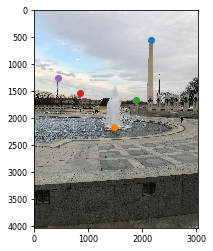

In [16]:
# Plot the GCP's using optimally estimated pose.
plt.rcParams.update({'font.size': 8})
for x in range(0,len(final_coords)):
    #plt.text(final_coords[x][0], final_coords[x][1], gcps[x][5])
    plt.scatter(final_coords[x][0], final_coords[x][1])
im = plt.imread('national_mall.jpg')
implot = plt.imshow(im)